*Goal:* Build a Model to classify tweets as positive or negative.

**Questions to take Note of**
1. Find the number of positive and negative reviews
2. Find the proportion of positive and negative reviews
3. How long is the longest review
4. How long is the shortest review

In [1]:
import numpy as np
import pandas as pd
import pickle

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from string import punctuation

import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('IMDB_Movie_Review_Dataset/Train.csv')
test_data = pd.read_csv('IMDB_Movie_Review_Dataset/Test.csv')
valid_data = pd.read_csv('IMDB_Movie_Review_Dataset/Valid.csv')

def data(dataframe):
    """Function to rename a dataframe"""
    return dataframe.rename(columns = {'text':'review'})

# I decided to join the train data together with the validation data
train_data = train_data.append(valid_data)

train_data = data(train_data).reset_index(drop=True)
test_data = data(test_data).reset_index(drop=True)

train_data.head()

,review,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


## Data Preprocessing

In [3]:
# Load the custom stopwords
with open('stopwords_json.txt', 'r') as f:
    stopwords_json = f.read()
    f.close()

In [4]:
# Initialize the TfidfVectorizer, Lemmatizer and stopwords
tfidfVect = TfidfVectorizer(use_idf=True)
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stop_words_json = set(stopwords_json)
# Combine the punctuation with stopwords in nltk and stopwords in json
STOPWORDS_PUNCT = set.union(stop_words, stop_words_json, punctuation)

In [5]:
def preprocess_text(text):
    """Function to clean text from irrelevant words and symbols"""
    sentence = []
    
    # Tokenize and lowercase all alphabet
    tokens = [i.lower() for i in word_tokenize(text)]
    
    # Part of speech
    tags = pos_tag(tokens)
    
    for (token, tag) in tags:
        # Remove all irrelevant symbols from token
        token = re.sub(r"([0-9]+|[-_@./&+#]+|``)", '', token)
        token = re.sub(r"@[A-Za-z0-9_]+", '', token)

        # Grab the positions of the nouns(NN), verbs(VB), adverb(RB), and adjective(JJ)
        if tag.startswith('NN'):
            position = 'n'
        elif tag.startswith('VB'):
            position = 'v'
        elif tag.startswith('RB'):
            position = 'r'
        else:
            position = 'a'

        lemmatized_word = lemmatizer.lemmatize(token, position)
        if lemmatized_word not in STOPWORDS_PUNCT:
            sentence.append(lemmatized_word)
    final_sent = ' '.join(sentence)
    final_sent = final_sent.replace("n't", 'not').replace('br', '').replace('ii', '').replace('iii', '')
    final_sent = final_sent.replace("'s", " ").replace("''", " ")
    return final_sent

train_review = train_data.review.copy()
test_review = test_data.review.copy()

train_data['preprocessed_review'] = train_review.apply(preprocess_text)
test_data['preprocessed_review'] = test_review.apply(preprocess_text)

In [6]:
train_data.head()

,review,label,preprocessed_review
0,I grew up (b. 1965) watching and loving the Th...,0,grow watching love thunderbird mate school ...
1,"When I put this movie in my DVD player, and sa...",0,put movie dvd player sit coke chip expectation...
2,Why do people who do not know what a particula...,0,people know particular time past like feel nee...
3,Even though I have great interest in Biblical ...,0,even though great interest biblical movie bore...
4,Im a die hard Dads Army fan and nothing will e...,1,im die hard dad army fan nothing ever change ...


In [7]:
test_data.head()

,review,label,preprocessed_review
0,I always wrote this series off as being a comp...,0,always write series complete stinkfest jim bel...
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0,st watch dirsteve purcell typical mary kat...
2,This movie was so poorly written and directed ...,0,movie poorly write direct fell asleep minute ...
3,The most interesting thing about Miryang (Secr...,1,interesting thing miryang secret sunshine acto...
4,"when i first read about ""berlin am meer"" i did...",0,first read berlin meer not expect much tho...


How many positive (1) and negative (0) reviews

In [8]:
print('Count of positive and negative for train review\n',train_data.label.value_counts())
print('\nCount of positive and negative for test review\n',test_data.label.value_counts())

Count of positive and negative for train review
 0    22505
1    22495
Name: label, dtype: int64

Count of positive and negative for test review
 1    2505
0    2495
Name: label, dtype: int64


Percentage of positive and negative review

In [9]:
print('Percentage of positive and negative for train review\n',train_data.label.value_counts() / len(train_data))
print('\nPercentage of positive and negative for test review\n',test_data.label.value_counts() / len(test_data))

Percentage of positive and negative for train review
 0    0.500111
1    0.499889
Name: label, dtype: float64

Percentage of positive and negative for test review
 1    0.501
0    0.499
Name: label, dtype: float64


*The data is balanced, therefore, no bias present*

How long is the longest and shortest review

In [10]:
length_reviews = train_data.preprocessed_review.str.len()
print('The longest for train review is {}'.format(max(length_reviews)))

length_reviews = train_data.preprocessed_review.str.len()
print('The shortest for train review is {}'.format(min(length_reviews)))

The longest for train review is 8811
The shortest for train review is 17


In [11]:
length_reviews = test_data.preprocessed_review.str.len()
print('The longest for test review is {}'.format(max(length_reviews)))

length_reviews = test_data.preprocessed_review.str.len()
print('The shortest for test review is {}'.format(min(length_reviews)))

The longest for train review is 8476
The shortest for train review is 43


In [12]:
prep_train = train_data[['preprocessed_review', 'label']]
prep_test = test_data[['preprocessed_review', 'label']]

In [13]:
prep_train.head()

,preprocessed_review,label
0,grow watching love thunderbird mate school ...,0
1,put movie dvd player sit coke chip expectation...,0
2,people know particular time past like feel nee...,0
3,even though great interest biblical movie bore...,0
4,im die hard dad army fan nothing ever change ...,1


In [14]:
def labels(x):
    """Function to separate the labels, 0 as Negative and 1 as Positive"""
    if x == 0:
        return 'Negative'
    return 'Positive'

label = prep_train.label.copy()
prep_train['labels'] = label.apply(labels)
data = prep_train.drop('label', axis=1)

In [15]:
data.head(10)

,preprocessed_review,labels
0,grow watching love thunderbird mate school ...,Negative
1,put movie dvd player sit coke chip expectation...,Negative
2,people know particular time past like feel nee...,Negative
3,even though great interest biblical movie bore...,Negative
4,im die hard dad army fan nothing ever change ...,Positive
5,terrible movie everyone say make laugh cameo ...,Negative
6,finally watch shock movie last night disturb m...,Positive
7,catch film azn cable sound like would good fi...,Negative
8,may remake autumn tale eleven year director...,Positive
9,super ex girlfriend turn pleasant surprise rea...,Positive


In [16]:
# Let's split the dataset into positive and negative so as to visualize the frequency of the words
pos = data[data.labels == 'Positive']
neg = data[data.labels == 'Negative']

In [17]:
pos.head()

,preprocessed_review,labels
4,im die hard dad army fan nothing ever change ...,Positive
6,finally watch shock movie last night disturb m...,Positive
8,may remake autumn tale eleven year director...,Positive
9,super ex girlfriend turn pleasant surprise rea...,Positive
10,ca not believe people look plot film laural h...,Positive


In [18]:
neg.head()

,preprocessed_review,labels
0,grow watching love thunderbird mate school ...,Negative
1,put movie dvd player sit coke chip expectation...,Negative
2,people know particular time past like feel nee...,Negative
3,even though great interest biblical movie bore...,Negative
5,terrible movie everyone say make laugh cameo ...,Negative


## Determining Word Density

### Visualize the Frequency of words

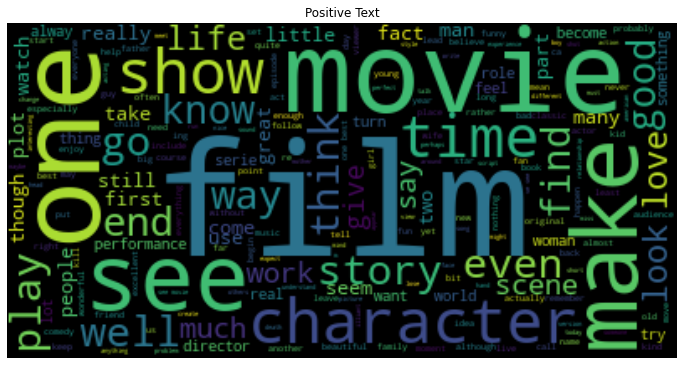

In [19]:
wordcloud = WordCloud(background_color='black').generate(' '.join(pos.preprocessed_review))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Positive Text')
plt.axis('off')
plt.show()

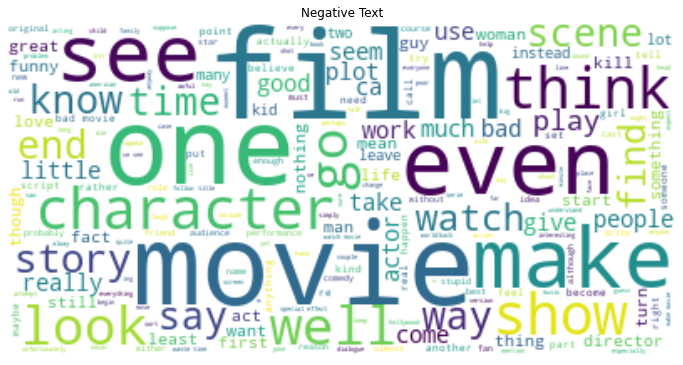

In [20]:
wordcloud = WordCloud(background_color='white').generate(' '.join(neg.preprocessed_review))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Negative Text')
plt.axis('off')
plt.show()

# Prepare Data for training

### Feature Engineering/Extraction

In [21]:
# In Feature Engineering we will convert our text documents to a matrix 
# of token counts e.g({'movie':0, 'film':1}) with CountVectorizer(), then transform the count matrix to
# a normalized tf-idf representation with TfidfTransformer(). After that, we train several transformers
# from sklearn.

# Convert the text documents to a matrix of token counts with CountVectorizer, then normalize with 
# TfidfTransformer and then store the transformed data. 
train_set = tfidfVect.fit_transform(prep_train.preprocessed_review)
print(train_set.shape)
test_set = tfidfVect.transform(prep_test.preprocessed_review)

# Now we need to split the labels from the data
train_label = prep_train.label
test_label = prep_test.label

with open('transformed.pkl', 'wb') as f:
    pickle.dump(tfidfVect, f)

(45000, 115406)


In [22]:
# Multinomial Naive Bayes Classifier
nb_clf = MultinomialNB()
nb_clf.fit(train_set, train_label)

MultinomialNB()

In [23]:
y_pred = nb_clf.predict(test_set)
print('Model Name: Multinomial Naive Bayes Classifier')
print(classification_report(y_pred=y_pred, y_true=test_label))

Model Name: Multinomial Naive Bayes Classifier
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2495
           1       0.88      0.86      0.87      2505

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



In [27]:
# Serialize the best Model to disk
with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(nb_clf, f)